In [1]:
import rpy2
import pandas as pd

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
# from pyper import R

%load_ext rpy2.ipython

utils = importr('utils')
# utils.install_packages('anthro')
# utils.install_packages('RM.weights')
pandas2ri.activate()

In [4]:
%%R
library(tidyverse)
library(haven)
library(TAM)
library(WrightMap)
if(!require('RM.weights')) {
  install.packages('RM.weights')
  library('RM.weights')
}

## Running the Rasch Model with Other tools

In [4]:
%%R
# Running the Rasch model
rasch_model <- tam(xx.nigeria)
# summary(rasch_model)

Error in as.matrix(resp) : object 'xx.nigeria' not found


RInterpreterError: Failed to parse and evaluate line '# Running the Rasch model\nrasch_model <- tam(xx.nigeria)\n# summary(rasch_model)\n'.
R error message: "Error in as.matrix(resp) : object 'xx.nigeria' not found"

**Observation**
* Mean Rasch `reliability` was 0.752

### Understanding the Rasch Model

In [15]:
%%R
item_prop <- rasch_model$item
item_prop

                       item    N          M    xsi.item  AXsi_.Cat1 B.Cat1.Dim1
fies_worried   fies_worried 2583 0.88811460 -2.58836883 -2.58836883           1
fies_healthy   fies_healthy 2583 0.90824623 -2.84891317 -2.84891317           1
fies_fewfoods fies_fewfoods 2583 0.89934185 -2.72851419 -2.72851419           1
fies_skipped   fies_skipped 2583 0.83817267 -2.07251752 -2.07251752           1
fies_ateless   fies_ateless 2583 0.87224158 -2.40807593 -2.40807593           1
fies_ranout     fies_ranout 2583 0.42237708  0.42277984  0.42277984           1
fies_hungry     fies_hungry 2583 0.48625629  0.09157318  0.09157318           1
fies_whlday     fies_whlday 2583 0.09485095  2.76609928  2.76609928           1


The number of **YES** answers, or, number of people who endorse a category increases monotonically with the item severity.

To see this, we can find the total number of people who endorsed the “yes” category for each `fies` item above.

The table provides the proportion who endorsed the higher category in the `M` column.

For instance, item Hls1 had 15.77% of people endorse the “agree” category (1= agree, 0= disagree). In the N column, we see that 317 people answered the item in total.

**The correlation between total number of "yes" per item and the estimated item severity can be computed as follows.**

In [16]:
%%R
# create a column in the item_prop object that has the total number of endorsements for each item
item_prop <- mutate(item_prop, total_endorsed =N*M)

cor(item_prop$xsi.item, item_prop$total_endorsed)

[1] -0.9987698


**Observation**

We see that the correlation between item severities and total endorsements per item is nearly perfect -.99. 

As the number of endorsements go down, the estimated severities of the item increase.

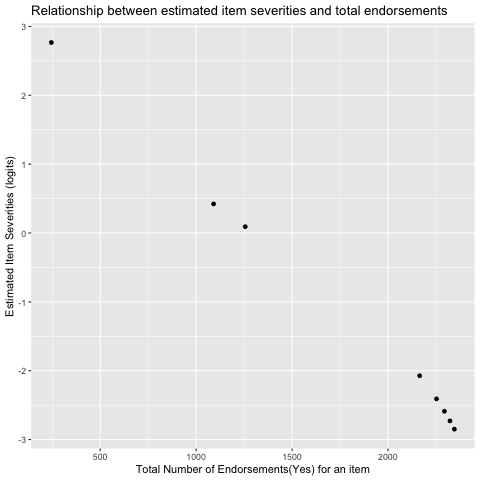

In [17]:
%%R
ggplot(item_prop, aes(x=total_endorsed, y=xsi.item)) + 
  geom_point() +
  ylab("Estimated Item Severities (logits)") +
  xlab("Total Number of Endorsements(Yes) for an item") +
  ggtitle("Relationship between estimated item severities and total endorsements")

### Item Severity

We’ll extract difficulties `(xsi)` from the `rasch_model` object

In [18]:
%%R
# Item severity
severities <- rasch_model$xsi
severities

                      xsi     se.xsi
fies_worried  -2.58836883 0.06808397
fies_healthy  -2.84891317 0.07373909
fies_fewfoods -2.72851419 0.07101950
fies_skipped  -2.07251752 0.05916399
fies_ateless  -2.40807593 0.06464626
fies_ranout    0.42277984 0.04503959
fies_hungry    0.09157318 0.04467650
fies_whlday    2.76609928 0.07122454


**Observation**
* In the result above, we can see the item severity in logits in the column `xsi` and the standard error for each item `se.xsi`. 
One way to think of what the standard error tells us is whether item severity may overlap or not.

* Higher `xsi` values indicate more severe items. For instance, item `fies_worried` is more severe than `fies_whlday`. The values are identified by constraining the mean of item severity to zero.

In [19]:
%%R
## Item difficulties vs their standard error
ggplot(severities, aes(x=xsi, y=se.xsi)) + geom_point() +
  ggtitle("Item severity and their standard error") +
  xlab("Estimated Item Severity") 
  ylab("Estimated Item Standard Errors")

$y
[1] "Estimated Item Standard Errors"

attr(,"class")
[1] "labels"


In [20]:
%%R
# Let's find out if the data fits the model.
fit <- tam.fit(rasch_model)
write.csv(fit$itemfit, file = "../data/fies_fit.csv",row.names=FALSE)
fit$itemfit

Item fit calculation based on 15 simulations
|**********|
|--------|
      parameter    Outfit   Outfit_t     Outfit_p Outfit_pholm     Infit
1  fies_worried 0.9575588 -0.9878948 3.232042e-01 4.714403e-01 0.9081346
2  fies_healthy 1.4071920  6.9642076 3.302572e-12 2.311800e-11 1.0133419
3 fies_fewfoods 1.2277063  4.3414323 1.415569e-05 5.662277e-05 0.9424637
4  fies_skipped 0.8305786 -5.0160527 5.274386e-07 2.637193e-06 0.8929855
5  fies_ateless 0.9530479 -1.1857522 2.357202e-01 4.714403e-01 0.8931125
6   fies_ranout 1.0461819  2.5057167 1.222035e-02 3.666105e-02 1.0076723
7   fies_hungry 1.0990647  5.4057509 6.453742e-08 3.872245e-07 1.0314557
8   fies_whlday 2.2047366 17.9456435 5.190581e-72 4.152465e-71 1.1369867
     Infit_t     Infit_p Infit_pholm
1 -2.0663293 0.038797401  0.19398701
2  0.2720821 0.785558857  1.00000000
3 -1.1888751 0.234488809  0.70346643
4 -3.0711459 0.002132389  0.01705911
5 -2.6294189 0.008553093  0.05987165
6  0.4271281 0.669286011  1.00000000
7  1.7553914 0.

### Visualizing Item Fit

We can use default `WrightMap` functionality to plot item fit statistics. 
In the fit object, `itemfit` is a dataframe containing various fit statistics. 

We’ll plot `infit` with a lowerbound of .70 (in mean-square error units) and an upper bound of 1.1

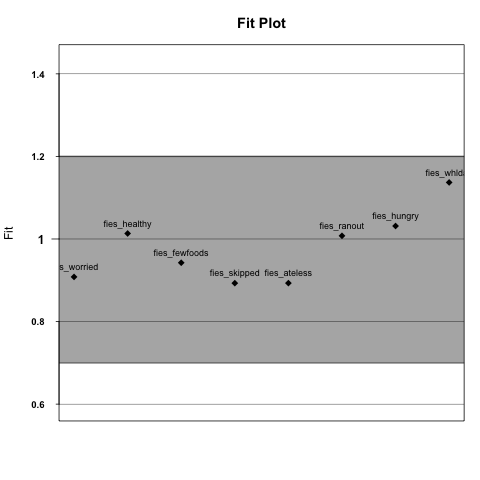

In [21]:
%%R
# Infit
infit <- fit$itemfit$Infit

upper_bound <- rep(x = 1.2, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

# running fitgraph
fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.nigeria))

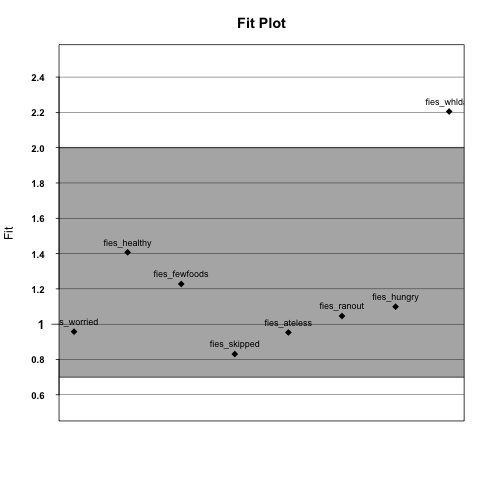

In [25]:
%%R
# # what about outfit?
outfit <- fit$itemfit$Outfit


upper_bound <- rep(x = 2.0, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 


fitgraph(fitEst = outfit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(xx.nigeria))

**Observation**
* The weighted **infit** statistics for the FIES data in our study were within the acceptable range of 0.7–1.2.

### Summary of item infit statistics for round 6 survey datasets conducted in Nigeria in 2024

This section summarizes findings on data quality and consistency with assumptions of the
Rasch measurement model and presents the results obtained from the datasets collected.

In [ ]:
fies_fit = pd.read_csv("../data/fies_fit.csv", index_col=False)
fies_fit

### Observation

**Item Infit Statistic**

In spite of the wide range of cultures and languages in which the FIES-SM was administered
and the attendant challenges of translation, the fit of all the items to the measurement model
was remarkably good. 


**Infit statistics** 
* For each item were between 0.8 and 1.02.
* The highest mean infit (1.02) was for the `fies_hungry`
* The lowest mean infits were for `fies_ateless` (0.862) and `fies_worried`(0.867).



**Item Outfit Statistics**

Outfit statistics are sensitive to even a few cases with highly improbable response patterns. They
are useful primarily for identifying items that may be inconsistently understood by a small
proportion of respondents, but may also reflect just one or two careless responses or recordings
by the interviewer. The acceptable range of `outfit` is < 2.

**Outfit statistics** 

* For each item were between 0.72 and 1.73. This is within the acceptable range.
* The most severe item, `fies_whlday`, had the highest mean outfit (1.731).
* The lowest mean outfit were for `fies_skipped` (0.72) and `fies_ateless`(0.99).

### **Impact**
* The low infit shows that the items were most consistently associated with the latent trait measured by all of the
items.
* The outfit statistics computed for the 2024 round 6 application of the FIES for Nigeria
do not indicate  model misfit or distortion of severity estimates for respondents to warrant any change in the estimation procedure


Overall, 
* The weighted **infit** statistics for the FIES data in our study were within the acceptable range of 0.7–1.2, which verified that the FIES is a reliable and valid measure to assess food insecurity in this population. Likewise the `outfit` range which is <2.
* Mean Rasch Model `reliability` was 0.752 . This level of reliability for a scale comprising just eight items reflect reasonably good model fit. The acceptable value is >0.7.
* Because all the items falls within the acceptable range, there are no problematic item to report

In [15]:
%%R

# Define the data file path
file_path <- "../data/fao_round6_ng_clean_data.csv"

# Read the CSV file while selecting columns using the regex pattern
fies_ng <- read_csv(file_path)

fies_ng <- fies_ng %>%
  select(matches("^(weight|fies)"))

# Column name
colnames(fies_ng) = c("WORRIED", "HEALTHY", 
                      "FEWFOODS", "SKIPPED",
                     "ATELESS", "RUNOUT", "HUNGRY")


# Convert the values to integers
# df <- as.data.frame(lapply(df, as.integer))

# # Drop values with extreme scores 
# fies.ng <- subset(fies.ng, !(fies_rawscore %in% c(0.0, 8.0)))

# dim(df)
# head(fies.ng)
# write.csv(fies.ng, "../data/fies_rasch_analysis.csv", row.names = FALSE)


Rows: 3438 Columns: 197
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (25): country, state, local_govt_area, hh_agricactivity, hh_gender, hh_...
dbl (172): hh_size, hh_maritalstat, weight_final, hh_wealth_water, hh_wealth...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Error in optim(seq(-3, 3, length.out = k), wle.fit, method = "BFGS", control = list(maxit = max.it)) : 
  initial value in 'vmmin' is not finite


RInterpreterError: Failed to parse and evaluate line '\n# Define the data file path\nfile_path <- "../data/fao_round6_ng_clean_data.csv"\n\n# Read the CSV file while selecting columns using the regex pattern\nfies_ng <- read_csv(file_path)\n\nfies_ng <- fies_ng %>%\n  select(matches("^(weight|fies)"))\n\n# Column name\ncolnames(fies_ng) = c("WORRIED", "HEALTHY", \n                      "FEWFOODS", "SKIPPED",\n                     "ATELESS", "RUNOUT", "HUNGRY")\n\nres = RM.w(fies_ng)\n# Convert the values to integers\n# df <- as.data.frame(lapply(df, as.integer))\n\n# # Drop values with extreme scores \n# fies.ng <- subset(fies.ng, !(fies_rawscore %in% c(0.0, 8.0)))\n\n# dim(df)\n# head(fies.ng)\n# write.csv(fies.ng, "../data/fies_rasch_analysis.csv", row.names = FALSE)\n'.
R error message: 'Error in optim(seq(-3, 3, length.out = k), wle.fit, method = "BFGS", control = list(maxit = max.it)) : \n  initial value in \'vmmin\' is not finite'

In [13]:
%%R 
fies_ng

# A tibble: 3,438 × 10
   weight_final fies_worried fies_healthy fies_fewfoods fies_skipped
          <dbl>        <dbl>        <dbl>         <dbl>        <dbl>
 1        0.198            1            1             1            1
 2        0.188            1            1             1            1
 3        0.188            1            1             1            1
 4        0.198            1            1             1            1
 5        0.198            1            1             1            1
 6        0.188            1            1             1            1
 7        0.198            1            1             1            1
 8        0.122            1            1             1            1
 9        0.122            1            1             1            1
10        0.122            1            1             0            0
# ℹ 3,428 more rows
# ℹ 5 more variables: fies_ateless <dbl>, fies_ranout <dbl>, fies_hungry <dbl>,
#   fies_whlday <dbl>, fies_rawscore <dbl>
# ℹ Us